In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
import matplotlib.pyplot as plt
from src.dataloader import DataloaderEuropean1D, DataloaderAmerican1D
from src.PINN import PINN
DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)

In [5]:
def make_training_plot(filename : str, for_validation : bool = False):
    types_of_loss = ["total_loss", "loss_boundary",
                     "loss_pde", "loss_expiry", "loss_lower", "loss_upper"]
    if for_validation:
        X_loss = np.loadtxt("results/validation_" + filename + ".txt")
    else:
        X_loss = np.loadtxt("results/loss_" + filename + ".txt")
    
    df_loss = pd.DataFrame(columns = types_of_loss, data = X_loss)
    df_loss["epoch"] = np.arange(1, len(df_loss) + 1)
    df_melted = df_loss.melt(id_vars = "epoch", value_vars=types_of_loss, var_name='Category', value_name = "Loss")

    y_name = "Validation loss " if for_validation else "Loss"
    fig = px.line(df_melted, x = "epoch", y = "Loss", color = "Category", log_y = True)
    fig.show()

In [ ]:
filename = "multi_1_560"
make_training_plot(filename)


In [ ]:
filename = "multi_1_560"
make_training_plot(filename, True)

In [24]:
def make_heat_map(layers : list[int], nodes : list[int], filename : str):
    data = np.zeros((len(layers), len(nodes)))
    
    for i, layer in enumerate(layers):
        for j, node in enumerate(nodes):
            X_loss = np.loadtxt("results/" + filename + f"_{layer}_{node}" ".txt")
            data[i,j] = np.min(X_loss[:,1])
    
    #np.savetxt("results/"+filename + "_lowest_MSE" ".txt", data)
    df = pd.DataFrame(data, index=layers, columns=nodes)
    formatted_df = df.applymap(lambda x: f'{x:.2e}')

    fig = px.imshow(df, 
                labels=dict(x="Columns", y="Rows", color="Value"), 
                text_auto=True,  # This automatically adds values in the cells
                aspect="auto")

    fig.update_traces(text=formatted_df.values, texttemplate="%{text}")
    # Show the plot
    fig.show()

In [ ]:
make_heat_map(["1","2","3","4","5","6","7"], ["10","20","40","80","160","320","560"], "loss_multi")

In [ ]:
make_heat_map(["1","2","3","4","5","6","7"], ["10","20","40","80","160","320","560"], "validation_multi")

In [5]:
def make_heat_map_activation(filename : str, activation_functions : list[str], layers : list[str]):
    data = np.loadtxt(filename)

    df = pd.DataFrame(data, index=activation_functions, columns=layers)
    formatted_df = df.applymap(lambda x: f'{x:.2e}')

    fig = px.imshow(df, 
                labels=dict(x="Layers", y="Activation function", color="Value"), 
                text_auto=True,  # This automatically adds values in the cells
                aspect="auto")

    fig.update_traces(text=formatted_df.values, texttemplate="%{text}")
    # Show the plot
    fig.show()


In [ ]:
make_heat_map_activation("important_results/different_activation.txt", ["ReLU", "LeakyReLU", "Sigmoid", "Tanh"], ["1", "2", "4", "8", "16"])

In [2]:
def make_heat_map_learning_rate(filename : str, learning_rates : list[str], batch_sizes : list[str], format : str):
    data = np.loadtxt(filename)

    df = pd.DataFrame(data, index=learning_rates, columns=batch_sizes)
    formatted_df = df.applymap(format)

    fig = px.imshow(df, 
                labels=dict(x="Batch size", y="Learning rate", color="Batch size"), 
                text_auto=True,  # This automatically adds values in the cells
                aspect="auto")

    fig.update_traces(text=formatted_df.values, texttemplate="%{text}")
    # Show the plot
    fig.show()

In [4]:
make_heat_map_learning_rate("important_results/MSE_lr_1d_european.txt", ["1e-2", "5e-3", "1e-3", "5e-4", "1e-4", "5e-5"], ["100", "1_000", "5_000", "10_000"], lambda x: f'{x:.2e}')

/tmp/ipykernel_3107194/4162884187.py:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [5]:
make_heat_map_learning_rate("important_results/epoch_lr_1D_european.txt", ["1e-2", "5e-3", "1e-3", "5e-4", "1e-4", "5e-5"], ["100", "1_000", "5_000", "10_000"], lambda x: f'{x:.0f}')

/tmp/ipykernel_3107194/4162884187.py:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [5]:
def compare_model_with_analytical_1D(model_name, dataloader):
    S_range, t_range = dataloader.S_range, dataloader.time_range

    model = PINN(2, 1, 300, 5).to(DEVICE)
    model.load_state_dict(torch.load(model_name, weights_only=True))

    s = np.linspace(S_range[0], S_range[1], 100)
    t = np.linspace(t_range[0], t_range[1], 100)
    s_grid, t_grid = np.meshgrid(s, t)
    s_flat = s_grid.flatten()
    t_flat = t_grid.flatten()

    # Create a 2D tensor from the flattened arrays
    X_test = torch.tensor(np.column_stack((t_flat, s_flat)), dtype=torch.float)
    X_test_scaled = dataloader.normalize(X_test)
    # X_test_norm = euro_call_data.normalize(X_test)
    y_analytical_test = dataloader.get_analytical_solution(X_test[:,1],X_test[:,0])
    model.eval()
    with torch.no_grad():
        y_pinn_test = model(X_test_scaled)
    
    err = (y_pinn_test-y_analytical_test.reshape(y_analytical_test.shape[0],-1)).cpu().numpy()
    loss_mse = np.square(err).sum()/(len(err))
    print(f"MSE net: {loss_mse:.3f}")

    fig = plt.figure(figsize=(14,7))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(s_grid, t_grid, y_analytical_test.cpu().numpy().reshape(s_grid.shape), cmap = "viridis")
    ax.set_title("Analytical Soln")
    ax.set_xlabel("Spot Price")
    ax.set_ylabel(f"current time (t), $t \in {[t_range]}$")
    ax.set_zlabel("Call price")
    ax.view_init(elev=20, azim=-120)
    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(s_grid, t_grid, y_pinn_test.cpu().numpy().reshape(s_grid.shape), cmap = "viridis")
    ax.set_title("PINN prediction")
    ax.set_xlabel("Spot Price")
    ax.set_ylabel(f"current time (t), $t \in {[t_range]}$")
    ax.set_zlabel("Call price")
    ax.view_init(elev=20, azim=-120)
    plt.show()
    #plt.savefig(experiment_dir+f"/true_vs_pred_final.jpg")
    fig = plt.figure(figsize=(14,7))
    ax = fig.add_subplot(121, projection='3d')
    err = y_pinn_test.cpu().numpy().reshape(s_grid.shape) - y_analytical_test.cpu().numpy().reshape(s_grid.shape)
    ax.plot_surface(s_grid, t_grid, err, cmap = "viridis")
    ax.plot_surface(s_grid, t_grid, np.zeros(err.shape), color = "grey")
    ax.set_title("Analytical Soln - Predicted")
    ax.set_xlabel("Spot Price")
    ax.set_ylabel("Time to expiry")
    ax.set_zlabel("Call price")
    ax.view_init(elev=20, azim=-120)
    plt.show()


<>:31: SyntaxWarning: invalid escape sequence '\i'
<>:38: SyntaxWarning: invalid escape sequence '\i'
<>:31: SyntaxWarning: invalid escape sequence '\i'
<>:38: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_2456898/3441071041.py:31: SyntaxWarning: invalid escape sequence '\i'
  ax.set_ylabel(f"current time (t), $t \in {[t_range]}$")
/tmp/ipykernel_2456898/3441071041.py:38: SyntaxWarning: invalid escape sequence '\i'
  ax.set_ylabel(f"current time (t), $t \in {[t_range]}$")


In [ ]:
dataloader = DataloaderEuropean1D([0,1], [0, 100], 20, 0.03, 0.25, DEVICE)
compare_model_with_analytical_1D("models/epoch_9985_test_analytical.pth", dataloader)

MSE net: nan


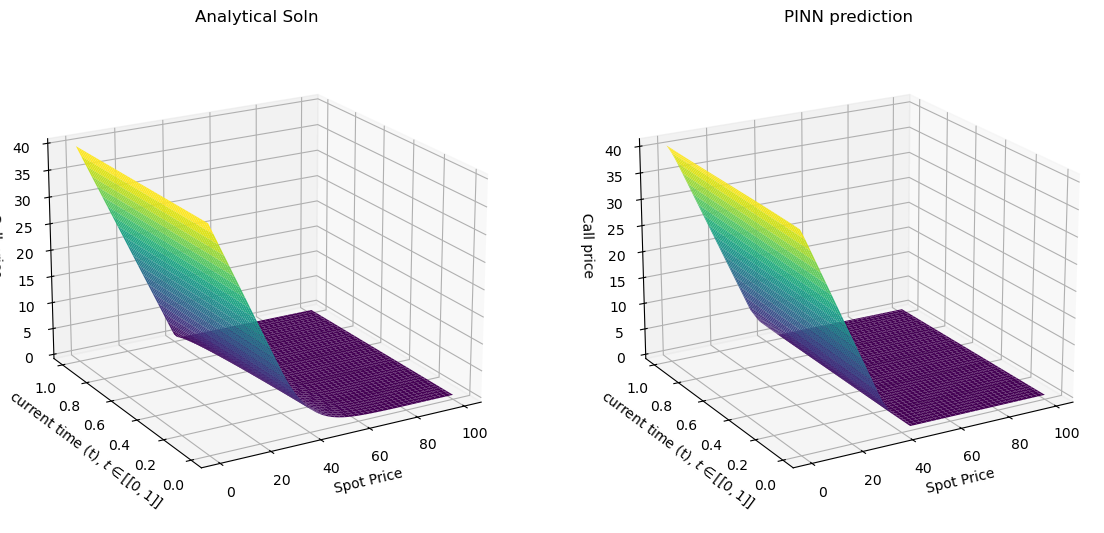

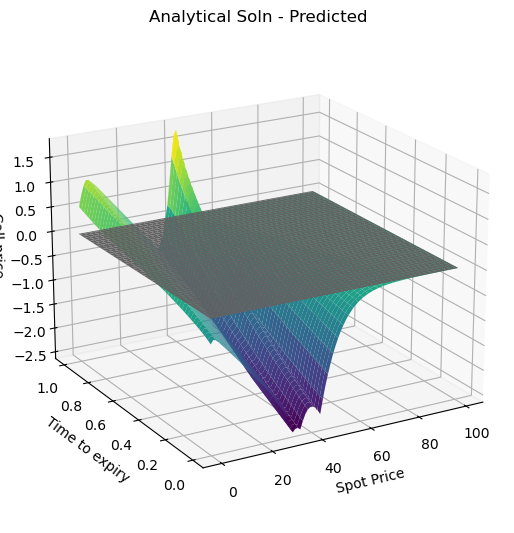

In [6]:
dataloader = DataloaderAmerican1D([0, 1], [0, 100], 40, 0.04, 0.25, DEVICE)
compare_model_with_analytical_1D("models/epoch_9941_america_test.pth", dataloader)

In [23]:
#X_analytical = np.loadtxt("results/analytical_test.txt")
#X_validation_data = np.loadtxt("results/validation_data.txt")

In [8]:
#df_analytical = pd.DataFrame(X_analytical, columns = ["value"])
#df_validation_data = pd.DataFrame(X_validation_data, columns = ["t", "S"])

In [38]:
def make_std_plot(filename):
    loss = np.loadtxt("results/average_loss_" + filename)
    std_loss = np.loadtxt("results/std_loss_" + filename)

    loss_upper = loss + std_loss
    loss_lower = loss - std_loss
    x_loss = np.arange(1, len(loss) + 1)

    val = np.loadtxt("results/average_validation_" + filename)
    std_val = np.loadtxt("results/std_validation_" + filename)

    val_upper = val + std_val
    val_lower = val - std_val
    x_val = np.arange(1, len(loss) + 1, 30)

    fig = make_subplots(rows=2, cols=1, subplot_titles=("Plot 1", "Plot 2"))

    fig.add_trace(go.Scatter(x=x_loss[1000::10], y=loss[1000::10], mode='lines+markers', name='Data 1', line=dict(color='red')), row=1, col=1)
    fig.add_trace(go.Scatter(x=x_loss[1000::10], y=loss_upper[1000::10], fill=None, mode='lines', line=dict(color='rgba(255,0,0,0)')), row=1, col=1)
    fig.add_trace(go.Scatter(x=x_loss[1000::10], y=loss_lower[1000::10], fill='tonexty', mode='lines', line=dict(color='rgba(255,0,0,0.2)')), row=1, col=1)

    # Second plot (y2 with shaded error band)
    fig.add_trace(go.Scatter(x=x_val, y=val, mode='lines+markers', name='Data 2', line=dict(color='blue')), row=2, col=1)
    fig.add_trace(go.Scatter(x=x_val, y=val_upper, fill=None, mode='lines', line=dict(color='rgba(0,0,255,0)')), row=2, col=1)
    fig.add_trace(go.Scatter(x=x_val, y=val_lower, fill='tonexty', mode='lines', line=dict(color='rgba(0,0,255,0.2)')), row=2, col=1)

    #fig.update_yaxes(type='log', row=1, col=1)  # Log scale for first plot
    #fig.update_yaxes(type='log', row=2, col=1)  # Log scale for second plot
    # Update layout
    fig.update_layout(height=600, width=800, title_text="2x1 Plot with Standard Deviation")

    # Show the plot
    fig.show()

In [39]:
for cur in ["lr_1", "lr_2", "lr_3", "lr_4"]:
    make_std_plot(cur)